This notebook employs the Trester algorithm for calculating diffraction
patterns using Fourier transform method

In [1]:
from numpy import exp, zeros, ones, complex128
from scipy.fftpack import fft2
from numba import jit, prange
from pylab import plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.fftpack import fft2, ifft2
from scipy.fftpack import fft, ifft
from scipy.fftpack import fftshift, ifftshift
from numpy import exp, sin, cos, pi, sqrt, diff
from numba import jit
from scipy import signal
from scipy.special import fresnel

std_figsize = (10.0, 5.0)

In [2]:
@jit(nopython=True)
def tresterModifiedAperture(aperture, N):
    modified_aperture = zeros((N, N), dtype=complex128)
    c1 = 1.0j * pi / N
    for i in prange(N):
        for k in prange(N):
            c2 = i * i + k * k
            modified_aperture[i,k] = aperture[i,k] * exp(c1 * c2)
    return modified_aperture

def fresnelDiffraction(aperture, N):
    modified_aperture = tresterModifiedAperture(aperture, N) 
    transform = (fft2(modified_aperture)) / N
    return abs(transform)**2

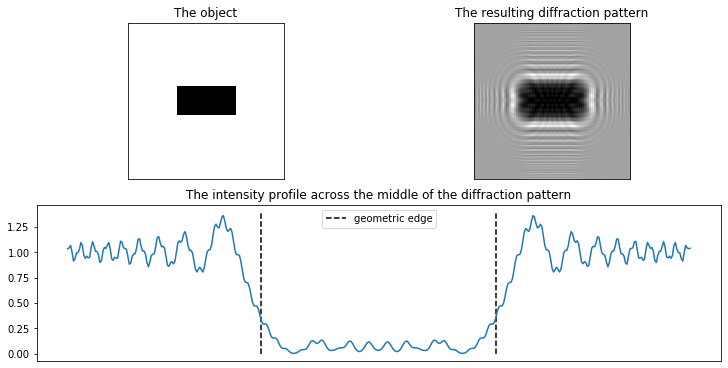

In [3]:
# Demo of the Trester algorithm for computing the diffraction pattern of an arbitrary object

N = 1024  # some convenient power of 2 will provide optimal input for fft2()

# aperture[i,j] is the pixel image of the asteroid/object. Set aperture[i,j] to 0.0 wherever
# the asteroid/object is blocking light from the star.

# As a demo, we use an object 80 x 160 pixels on a side at the center of the aperture.

# Start with all pixels 'lit' with unit intensity (1.0 0j) ...
aperture = ones((N, N), dtype=complex128)

# Then darken the pixels that represent the asteroid/object
for i in range(N // 2 - 40, N // 2 + 40):
    for k in range(N // 2 - 80, N // 2 + 80):
        aperture[i,k] = 0.0 
 
diffraction_pattern = fresnelDiffraction(aperture, N)

# Show an expanded view of the center sections of the object (on left) and 
# its diffraction pattern (on the right)

fig = plt.figure(constrained_layout=True, figsize=std_figsize)
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])  # ax3 uses two columns

ax1.set_title('The object')
ax1.tick_params(bottom=False, top=False, left=False, right=False)
ax1.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2.set_title('The resulting diffraction pattern')
ax2.tick_params(bottom=False, top=False, left=False, right=False)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax1.imshow(abs(aperture[300:725, 300:725]), cmap='gray');
ax2.imshow(diffraction_pattern[300:725, 300:725], cmap='gray');

ax3.set_title('The intensity profile across the middle of the diffraction pattern')
ax3.plot(diffraction_pattern[512, 300:725]);
ax3.vlines([N // 2 - 80 - 300, N // 2 + 80 - 300], ymin=0, ymax=1.4, ls='--', label='geometric edge');
ax3.legend(loc='upper center')
ax3.tick_params(bottom=False, labelbottom=False)

In [4]:
publish = False  # Set to True to cause plots to be rendered in their own interactive window
if publish:
    %pylab

In [5]:
# We use Numba to greatly speedup the calculation of the modified aperture.
@jit(nopython=True)
def calcField(N, fresnel_length_km, 
              knife_edge = False, asteroid = True, dual = False, aperture = False,
              diam_km = 1.0, overlap = 0.0):
    
    # This routine is a bit of a cobbled up mess.  It has the form it does so that I could generate
    # various source images based on 'flags' in the call. 
    #
    # It is able to generate and return a 'tresterModifiedAperture' for ...
    #
    #    an asteroid of any desired radius, including very large radius values
    #    a knife edge at a standard position
    #    a contact binary asteroid --- both elements have equal radius --- they can overlap (0.0 to 1.0)
    #
    # The contact binary image was cute, but ultimately had no pedagogical value and so was not used
    # in the paper.
    
    # None of the following values are used in the computation of the modified aperture field
    # in the plane of the asteroid, but are needed to interpret the result in useful
    # physical parameters of field-of-view (in kilometers) and fresnel lengths
    
    elz = 2 * fresnel_length_km * fresnel_length_km
    L_km = np.sqrt(elz * N) # km  (We're viewing an L_km x L_km image)
    x = np.linspace(-L_km / 2, L_km / 2, N)
    x_fl = x / fresnel_length_km  # x_fl is x expressed in fresnel lengths
    
    field = np.zeros((N, N), dtype=np.complex128) # Ensure the field is complex

    amplitude = 1.0 + 0.0j

    r = diam_km / 2.0
    r2 = r * r
    
    offset1 = -r
    offset2 = -(1.0 - 2 * overlap) * r - 2 * r
    
    if not dual:
        offset1 = offset2 = - r
        
    if knife_edge:
        edge_index = N // 2 - 1
        
    c1 = 1j * pi / N
    
    for i in range(N):
        for j in range(N):
            c2 = i * i + j * j
            if knife_edge:
                if j > edge_index:
                    field[i,j] = amplitude * np.exp(c1*c2)
            elif asteroid:
                in_target = ((x[j] - offset1) * (x[j] - offset1) + x[i]*x[i]) < r2
                in_target = in_target or ((x[j] - offset2) * (x[j] - offset2) + x[i]*x[i]) < r2
                if aperture:
                    if in_target:
                        field[i,j] = amplitude * np.exp(c1*c2)
                elif not in_target:
                    field[i,j] = amplitude * np.exp(c1*c2)
    
    return field, fresnel_length_km, L_km, x_fl

def indexToFresnelCoord(i, L_km, N, fresnel_length_km):
    return (i - (N // 2)) * L_km / ((N-1) * fresnel_length_km)

def tickIndices(size, L_km, N, fresnel_length_km):
    fs = [int(indexToFresnelCoord(i, L_km, N, fresnel_length_km) % size) for i in range(N)]
    return np.where(diff(fs) == -(size - 1))[0] + 0.5

def annotateImage(title, ax, N, L_km, fresnel_length_km, wavelength):

    ax.set_xlabel('fresnel units')
    ax.set_ylabel('fresnel units')

    ax.set_title(title)

    tick_list = tickIndices(5, L_km, N, fresnel_length_km) 
    ax.set_xticks(tick_list);
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(tick_list);
    funits = [int(round(indexToFresnelCoord(i, L_km, N, fresnel_length_km))) for i in tick_list]
    ax.set_xticklabels(funits);
    ax.set_yticklabels(funits);

# The following routine is used in this paper to generate 'analytic knife edge' diffraction curves
def diffraction_u(u: float, type_D_or_R: str) -> float:
    """
    Calculate normalized knife edge diffraction curve for a single wavelength using fresnel unit scale.

    When type_D_or_R == 'R' then a 'reappearance' curve
    results: it is 'dark' to the left of zero, and 'light' to the right of zero.

    When type_D_or_R == 'D' then a 'disappearance' curve
    results: it is 'light' to the left of zero, and 'dark' to the right of zero.

    :param u: fresnel unit
    :param type_D_or_R: either 'D' (disappearance) or 'R' (reappearance)
    :return: Normalized, single wavelength, diffraction intensity as a function of fresnel units
    """
    assert type_D_or_R in ['D', 'R'], 'Invalid type code given to diffraction_u'

    if type_D_or_R == 'D':
        u = -u
    ssa, csa = fresnel(u)
    return 0.5 * ((0.5 + csa)**2 + (0.5 + ssa)**2)

def fresnelLength(wavelength_nm, Z_AU):
    wavelength = wavelength_nm *1e-9 * 1e-3
    Z = Z_AU * 150e6
    return np.sqrt(wavelength * Z / 2)

fresnel length: 0.2779 km
L * L (field of view) = 17.79 km * 17.79 km


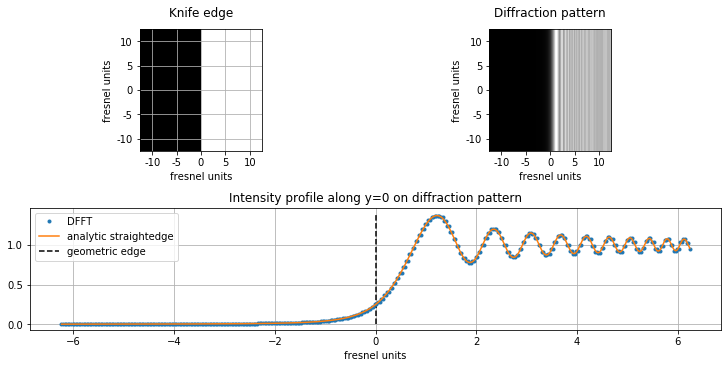

In [6]:
# This cell generates Figure 1 of the paper.  It shows the diffraction pattern of a knife edge
# and compares the DFFT version with the analytical version.  This is to 'prove' that the
# DFFT procedure works.

N = 1024 * 2  # number of sampling points along each image axes (global)
wavelength_nm = 400

# Felicia was an asteroid at 2.5752 au from earth and used in some early testing. 
fresnel_length_km = fresnelLength(wavelength_nm=400, Z_AU=2.5752)

image_type = 'knife_edge'

field, fresnel_length_km, L_km, x_fl = calcField(N, fresnel_length_km, knife_edge=True) 
           
print(f'fresnel length: {fresnel_length_km:0.4f} km')
print(f'L * L (field of view) = {L_km:0.4} km * {L_km:0.4} km')

fig = plt.figure(constrained_layout=True, figsize=std_figsize)
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1.matshow(abs(field), cmap='gray');
ax1.grid()
annotateImage('Knife edge', ax1, N, L_km, fresnel_length_km, wavelength_nm)

transform = (fft2(field)) / N
image = abs(transform)**2
ax2.matshow(image, cmap='gray');

annotateImage('Diffraction pattern', ax2, N, L_km, fresnel_length_km, wavelength_nm)

# We want to show a 'zoomed' version of the images and plots.  In part this is to
# suppress the 'edge effects' inherent in the DFFT process but also to give a
# clearer view of the interesting bits.

c = N // 2  # center
w = 400     # zoom width

ax1.set_xlim(c-w,c+w)
ax1.set_ylim(c-w,c+w)


ax2.set_xlim(c-w,c+w)
ax2.set_ylim(c-w,c+w)

w = 200
ax3 =fig.add_subplot(gs[1,:])
ax3.plot(x_fl[c-w:c+w],image[c,c-w:c+w],'.', label='DFFT');
ax3.plot(x_fl[c-w:c+w], diffraction_u(x_fl[c-w:c+w], 'R'), label='analytic straightedge');
ax3.set_xlabel('fresnel units')
ax3.set_title('Intensity profile along y=0 on diffraction pattern')
ax3.grid()
ax3.vlines([0], ymin=0, ymax=1.4, ls='--', label='geometric edge');
ax3.legend(loc='best');

if publish:
    plt.savefig('Figure1.jpg', format='jpg')

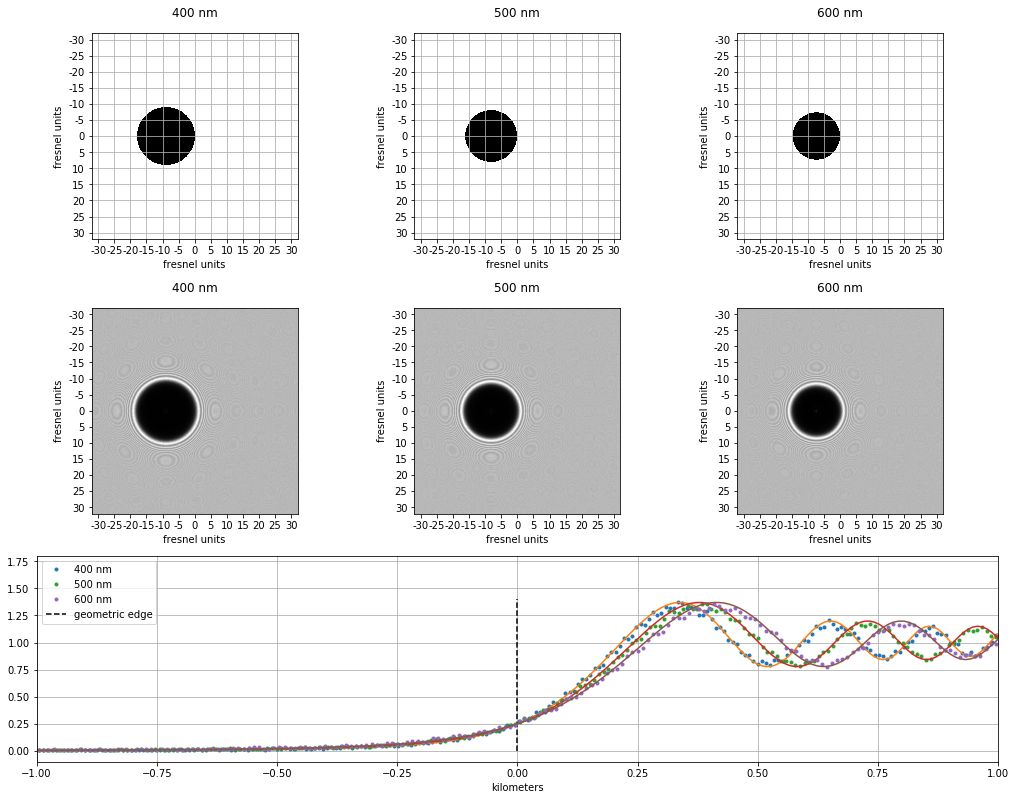

In [7]:
# This cell generates Figure 2 of the paper.  It's a big figure but should be helpful
# in visualizing the the mapping to fresnel space and back to physical space

N = 1024 * 2

fig = plt.figure(constrained_layout=True, figsize=(14, 11))
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])
ax7 = fig.add_subplot(gs[2,:])

rows_y = []
rows_x = []
rows_u = []

offset = 0.0
asteroid_diam_km = 5.0

for wavelength in [400, 425, 450, 475, 500, 525, 550, 575, 600]:
    fresnel_length_km = fresnelLength(wavelength_nm=wavelength, Z_AU=2.5752)
    n_off = int(round((offset / fresnel_length_km))*sqrt(N/2))
    field, fresnel_length_km, L_km, x_fl = calcField(N, fresnel_length_km, diam_km=asteroid_diam_km)
    transform = (fft2(field)) / N
    image = abs(transform)**2
    row = image[N // 2 + n_off, :]
    x_km = x_fl * fresnel_length_km

    rows_y.append(row)
    rows_x.append(x_km)
    rows_u.append(x_fl)
    if wavelength == 400:
        ax1.matshow(abs(field), cmap='gray')
        ax1.grid()
        ax4.matshow(image, cmap='gray')
        annotateImage('400 nm', ax1, N, L_km, fresnel_length_km, wavelength)
        annotateImage('400 nm', ax4, N, L_km, fresnel_length_km, wavelength)
    if wavelength == 500:
        ax2.matshow(abs(field), cmap='gray')
        ax2.grid()
        ax5.matshow(image, cmap='gray')
        annotateImage('500 nm', ax2, N, L_km, fresnel_length_km, wavelength)
        annotateImage('500 nm', ax5, N, L_km, fresnel_length_km, wavelength)
    if wavelength == 600:
        ax3.matshow(abs(field), cmap='gray')
        ax3.grid()
        ax6.matshow(image, cmap='gray')
        annotateImage('600 nm', ax3, N, L_km, fresnel_length_km, wavelength)
        annotateImage('600 nm', ax6, N, L_km, fresnel_length_km, wavelength)
    
    # Show plots for beginning, middle, and end wavelength values as a visual
    if wavelength in [400, 500, 600]:
        ax7.set_xlim(-1.0,1.0)
        ax7.set_ylim(-0.1, 1.8)
        ax7.grid()
        ax7.plot(x_km, row, '.', label=f'{wavelength} nm');
        ax7.plot(x_km, diffraction_u(x_fl, 'R'))
        
        
plt.vlines([0], ymin=0, ymax=1.4, ls='--', label='geometric edge');
plt.xlabel('kilometers');
plt.legend(loc='best');

if publish:
    plt.savefig('Figure2.jpg', format='jpg')

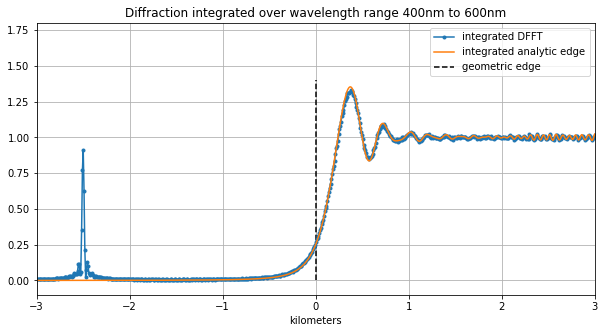

In [8]:
# This cell generates Figure 3 of the paper.  It is NOT standalone and uses data computed
# in the previous cell.  What we are showing in this figure is a simulation of the effect
# of light in a range of wavelengths on the observed diffration pattern.

# Note that the plot range includes the Poisson Spot at the center of the image.

from scipy import interpolate

y_avg = []
x_avg = []
yz_avg = []
xz_avg = []

k = len(rows_x)

# Generate an interpolation function f for each wavelength sample
f = []
for i in range(k):
    f.append(interpolate.interp1d(rows_x[i], rows_y[i], kind = 'quadratic', bounds_error=True))
             
for x in rows_x[0]:
    x_avg.append(x)
    sum = 0.0
    for i in range(k):
        sum += f[i](x)
    y_avg.append(sum / k)
    
# Generate an interpolation function f for each wavelength sample
f = []
for i in range(k):
    f.append(interpolate.interp1d(rows_x[i], diffraction_u(rows_u[i], 'R'), kind = 'quadratic', bounds_error=True))
             
for x in rows_x[0]:
    xz_avg.append(x)
    sum = 0.0
    for i in range(k):
        sum += f[i](x)
    yz_avg.append(sum / k) 
    
plt.figure(figsize=std_figsize)
plt.ylim(-0.1, 1.8)
plt.plot(x_avg, y_avg, '.-', label='integrated DFFT'); 
plt.plot(xz_avg, yz_avg, label='integrated analytic edge');
plt.vlines([-asteroid_diam_km, 0], ymin=0, ymax=1.4, ls='--', label='geometric edge');
plt.xlabel('kilometers')
plt.legend(loc='best')
plt.title('Diffraction integrated over wavelength range 400nm to 600nm')
plt.grid()
plt.xlim(-3.0, 3.0);

if publish:
    plt.savefig('Figure3.jpg', format='jpg')

fresnel length: 0.2779 km
L * L (field of view) = 17.79 km * 17.79 km


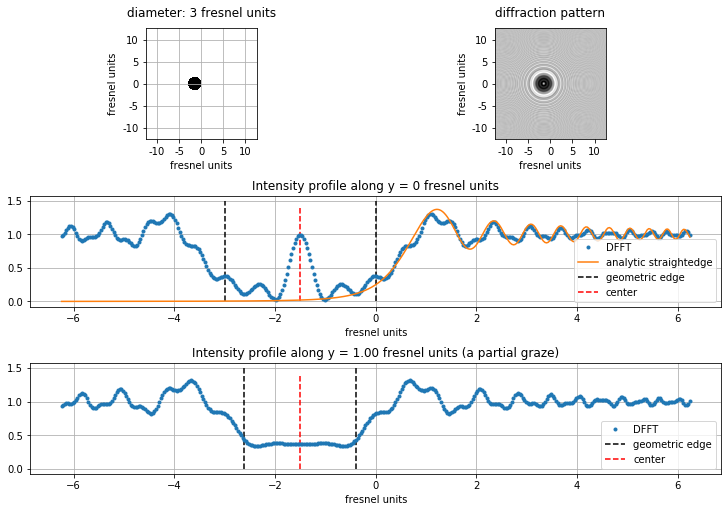

In [9]:
# This cell generates Figure 4 of the paper.  It shows the diffraction pattern of a small
# asteroid where small means just a few fresnel units in size

N = 1024 * 2  # number of sampling points along each image axes (global)
wavelength_nm = 400

samples_per_fresnel = int(np.sqrt(N))

# Felicia was an asteroid at 2.5752 au from earth and used in some early testing. 
fresnel_length_km = fresnelLength(wavelength_nm=400, Z_AU=2.5752)

num_fresnel_units = 3
diameter = num_fresnel_units * fresnel_length_km

field, fresnel_length_km, L_km, x_fl = calcField(N, fresnel_length_km, diam_km=diameter) 
transform = (fft2(field)) / N
image = abs(transform)**2
           
print(f'fresnel length: {fresnel_length_km:0.4f} km')
print(f'L * L (field of view) = {L_km:0.4} km * {L_km:0.4} km')

fig = plt.figure(constrained_layout=True, figsize=(10, 7))
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1.matshow(abs(field), cmap='gray');
ax1.grid()
annotateImage(f'diameter: {num_fresnel_units} fresnel units', ax1, N, L_km, fresnel_length_km, wavelength_nm)

ax2.matshow(image, cmap='gray');

annotateImage(f'diffraction pattern', ax2, N, L_km, fresnel_length_km, wavelength_nm)


# We want to show a 'zoomed' version of the images and plots to give a
# clearer view of the interesting bits.

c = N // 2  # center
w = 400     # zoom width

ax1.set_xlim(c-w,c+w)
ax1.set_ylim(c-w,c+w)


ax2.set_xlim(c-w,c+w)
ax2.set_ylim(c-w,c+w)

w = 200
ax3 =fig.add_subplot(gs[1,:])
ax3.plot(x_fl[c-w:c+w],image[c,c-w:c+w],'.', label='DFFT');
ax3.plot(x_fl[c-w:c+w], diffraction_u(x_fl[c-w:c+w], 'R'), label='analytic straightedge');
ax3.set_xlabel('fresnel units')
ax3.set_title('Intensity profile along y = 0 fresnel units')
ax3.grid()
ax3.vlines([0, -3], ymin=0, ymax=1.5, ls='--', label='geometric edge');
ax3.vlines([-num_fresnel_units/2], ymin=0, ymax=1.4, ls='--', color='r', label='center');
ax3.legend(loc='best');

w = 200
n_fresnel_offset = 1.0
offset = int(round(n_fresnel_offset * samples_per_fresnel))
ax4 =fig.add_subplot(gs[2,:])
ax4.plot(x_fl[c-w:c+w],image[c+offset,c-w:c+w],'.', label='DFFT');
#ax4.plot(x_fl[c-w:c+w], diffraction_u(x_fl[c-w:c+w], 'R'), label='analytic straightedge');
ax4.set_xlabel('fresnel units')
ax4.set_title(f'Intensity profile along y = {n_fresnel_offset:0.2f} fresnel units (a partial graze)')
ax4.grid()

# Figure out where the geomettrical edges are ...
r = num_fresnel_units / 2.0
b = np.sqrt(r * r - n_fresnel_offset * n_fresnel_offset)
ax4.vlines([b-r, -r-b], ymin=0, ymax=1.5, ls='--', label='geometric edge');

ax4.vlines([-num_fresnel_units/2], ymin=0, ymax=1.4, ls='--', color='r', label='center');
ax4.legend(loc='lower right');

if publish:
    plt.savefig('Figure4.jpg', format='jpg')